In [1]:
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns

In [2]:
def fetch_cos_value(seq_len, freq=0.01, noise=0.1):
    np.random.seed(101)
    x = np.arange(0.0, seq_len, 1.0)
    return np.cos(2 * np.pi * freq * x) + np.random.uniform(low=noise, high=noise, size=seq_len)

In [3]:
print(fetch_cos_value(10, freq=0.1))

[ 1.1         0.90901699  0.40901699 -0.20901699 -0.70901699 -0.9
 -0.70901699 -0.20901699  0.40901699  0.90901699]


In [4]:
# 데이터 불러오기

import FinanceDataReader as fdr
df_samsung = fdr.DataReader('005930')
df_samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-05-02,1340,1359,1284,1285,236600,NaN
1998-05-04,1266,1275,1230,1240,274250,-0.035019
1998-05-06,1219,1239,1204,1210,312220,-0.024194
1998-05-07,1213,1245,1210,1233,316361,0.019008
1998-05-08,1213,1232,1200,1210,333190,-0.018654
...,...,...,...,...,...,...
2022-06-30,57200,57600,57000,57000,18915142,-0.017241
2022-07-01,56900,57500,55900,56200,24982097,-0.014035
2022-07-04,56100,57400,55700,57100,17807126,0.016014


In [5]:
def date_obj_to_str(date_obj):
    return date_obj.strftime('%Y-%m-%d')

def save_pickle(something, path):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))

    with open(path, 'wb') as fh:
        pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)

def load_pickle(path):
    with open(path, 'rb') as fh:
        return pickle.load(fh)

def call_stock_price(symbol, from_date, to_date, cache_path="./tmp/prices/"):
    assert(from_date <= to_date)
    filename = "{}_{}_{}.pk".format(symbol, str(from_date), str(to_date))
    price_filepath = os.path.join(cache_path, filename)

    try:
        prices = load_pickle(price_filepath)
        print('loaded from', price_filepath)
    except IOError:
        historic = fdr.DataReader(symbol, start=date_obj_to_str(from_date), end=date_obj_to_str(to_date))
        prices = historic['Close'].tolist()
        save_pickle(prices, price_filepath)
        print('save into', price_filepath)

    return prices

In [6]:
import datetime

print(call_stock_price('GOOG', datetime.date(2020, 6, 1), datetime.date(2020, 6, 30)))

loaded from ./tmp/prices/GOOG_2020-06-01_2020-06-30.pk
[1431.82, 1439.22, 1436.38, 1412.18, 1438.39, 1446.61, 1456.16, 1465.85, 1403.84, 1413.18, 1419.85, 1442.72, 1451.12, 1435.96, 1431.72, 1451.86, 1464.41, 1431.97, 1441.33, 1359.9, 1394.97, 1413.61]


In [7]:
def format_dataset(values, temporal_features):
    feat_splits = [values[i: i+temporal_features] for i in range(len(values) - temporal_features)]
    features = np.vstack(feat_splits)
    labels = np.array(values[temporal_features:])

    return features, labels

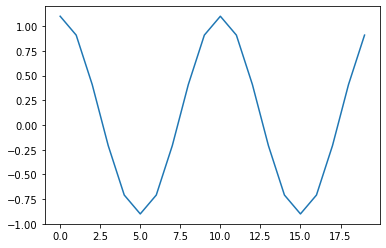

In [8]:
np.set_printoptions(precision=2)

cos_values = fetch_cos_value(20, freq=0.1)
plt.plot(cos_values)

In [9]:
feature_size = 5
minibatch_cos_x, minibatch_cos_y = format_dataset(cos_values, feature_size)
print('minibatch_cos_x shape=\n', minibatch_cos_x.shape,'\n')
print('minibatch_cos_y shape=\n',minibatch_cos_y.shape)

minibatch_cos_x shape=
 (15, 5) 

minibatch_cos_y shape=
 (15,)


In [10]:
minibatch_cos_x[0]

array([ 1.1 ,  0.91,  0.41, -0.21, -0.71])

Observation 0: x=[ 1.1   0.91  0.41 -0.21 -0.71], y=-0.9
Observation 1: x=[ 0.91  0.41 -0.21 -0.71 -0.9 ], y=-0.7090169943749475
Observation 2: x=[ 0.41 -0.21 -0.71 -0.9  -0.71], y=-0.20901699437494756
Observation 3: x=[-0.21 -0.71 -0.9  -0.71 -0.21], y=0.4090169943749472
Observation 4: x=[-0.71 -0.9  -0.71 -0.21  0.41], y=0.9090169943749473


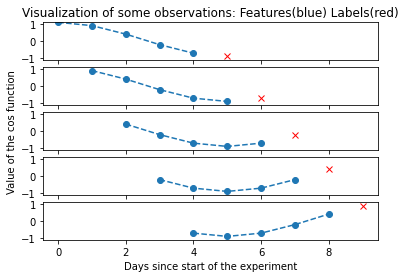

In [11]:
samples_to_plot = 5
f, axarr = plt.subplots(samples_to_plot, sharex=True)

for i in range(samples_to_plot):
    features = minibatch_cos_x[i, :]
    label = minibatch_cos_y[i]
    print(f'Observation {i}: x={features}, y={label}')
    plt.subplot(samples_to_plot, 1, i+1)
    axarr[i].plot(range(i, feature_size+i), features, '--o')
    axarr[i].plot([feature_size+i], label, 'rx')
    axarr[i].set_ylim([-1.1, 1.1])

plt.xlabel('Days since start of the experiment')
axarr[2].set_ylabel('Value of the cos function')
axarr[0].set_title('Visualization of some observations: Features(blue) Labels(red)')
plt.show()

loaded from ./tmp/prices/005930_2008-01-01_2022-06-30.pk
loaded from ./tmp/prices/000660_2008-01-01_2022-06-30.pk
loaded from ./tmp/prices/035420_2008-01-01_2022-06-30.pk
loaded from ./tmp/prices/035720_2008-01-01_2022-06-30.pk
loaded from ./tmp/prices/105560_2008-01-01_2022-06-30.pk


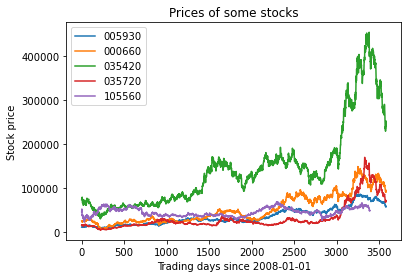

In [12]:
symbols = {'005930':'삼성전자',
           '000660':'SK하이닉스',
           '035420':'NAVER',
           '035720':'카카오',
           '105560':'KB금융'}
symbol_list = list(symbols.keys())
symbol_name = list(symbols.values())

start_date = datetime.date(2008,1,1)
end_date = datetime.date(2022,6,30)

ax = plt.subplot(1,1,1)
for sym in symbol_list:
    prices = call_stock_price(sym, start_date, end_date)
    ax.plot(range(len(prices)), prices, label=sym)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.xlabel(f'Trading days since {date_obj_to_str(start_date)}')
plt.ylabel('Stock price')
plt.title('Prices of some stocks')
plt.show()

In [13]:
def matrix_to_array(m):
    return np.asarray(m).reshape(-1)

In [22]:
def evaluate_ts(features, y_true, y_pred):
    print('Evaluation of predictions:')
    print('MSE:', np.mean(np.square(y_true-y_pred)))
    print('MAE:', np.mean(np.abs(y_true - y_pred)))

    print('Benchmark: if prediction == last feature')
    print('MSE:', np.mean(np.square(features[:, -1] - y_true)))
    print('MAE:', np.mean(np.abs(features[:, -1] - y_true)))

    plt.plot(matrix_to_array(y_true), 'b')
    plt.plot(matrix_to_array(y_pred), 'r--')
    plt.xlabel('Days')
    plt.ylabel('Predicted, True values')
    plt.title('Real(blue) VS Predicted(red)')
    plt.show()

    error = np.abs(matrix_to_array(y_pred) - matrix_to_array(y_true))
    plt.plot(error, 'r')
    fit = np.polyfit(range(len(error)), error, deg=1)
    plt.plot(fit[0] * range(len(error)) + fit[1], '--')
    plt.xlabel('Days')
    plt.ylabel('Prediction error L1 norm')
    plt.title('Prediction error')
    plt.show()

In [23]:
# tensorflow version == 2
# tf.compat.v1: version 1과 호환되게 해줌

import tensorflow as tf
from tensorflow_addons import rnn

# 기존 그래프를 삭제하고 reset 시켜 중복되는 것을 방지
# tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(101)

In [44]:
feat_dimension = 20
train_size = 250
test_size = 250
lr = 0.1
optimizer = tf.compat.v1.train.AdamOptimizer
n_epocs = 100

In [25]:
cos_values = fetch_cos_value(train_size + test_size + feat_dimension)
minibatch_cos_x, minibatch_cos_y = format_dataset(cos_values, feat_dimension)
train_x = minibatch_cos_x[:train_size, :].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_x = minibatch_cos_x[train_size:, :].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)

tf.compat.v1.disable_eager_execution()
X_tf = tf.compat.v1.placeholder('float', shape=(None, feat_dimension), name='X')
y_tf = tf.compat.v1.placeholder('float', shape=(None, 1), name='y')

In [26]:
def regression_ANN(x, weights, biases):
    return tf.add(biases, tf.matmul(x, weights))

In [47]:
weights = tf.Variable(tf.compat.v1.truncated_normal([feat_dimension, 1], mean=0.0, stddev=1.0), name='weights')
biases = tf.Variable(tf.zeros([1,1]), name='biases')

y_pred = regression_ANN(X_tf, weights, biases)
cost = tf.reduce_mean(tf.square(y_tf - y_pred))
train_op = optimizer(lr).minimize(cost)

In [28]:
train_op

<tf.Operation 'Adam_1' type=NoOp>

Testing iteration 0 MSE= 10.153103
Testing iteration 1 MSE= 9.33085
Testing iteration 2 MSE= 8.544829
Testing iteration 3 MSE= 7.7952085
Testing iteration 4 MSE= 7.082253
Testing iteration 5 MSE= 6.406356
Testing iteration 6 MSE= 5.7678204
Testing iteration 7 MSE= 5.1668262
Testing iteration 8 MSE= 4.603425
Testing iteration 9 MSE= 4.0775304
Testing iteration 10 MSE= 3.5889096
Testing iteration 11 MSE= 3.137185
Testing iteration 12 MSE= 2.7218235
Testing iteration 13 MSE= 2.342132
Testing iteration 14 MSE= 1.9972601
Testing iteration 15 MSE= 1.6861964
Testing iteration 16 MSE= 1.4077717
Testing iteration 17 MSE= 1.1606648
Testing iteration 18 MSE= 0.94340944
Testing iteration 19 MSE= 0.75440496
Testing iteration 20 MSE= 0.591931
Testing iteration 21 MSE= 0.45416167
Testing iteration 22 MSE= 0.33918703
Testing iteration 23 MSE= 0.24503277
Testing iteration 24 MSE= 0.1696844
Testing iteration 25 MSE= 0.111111045
Testing iteration 26 MSE= 0.067291714
Testing iteration 27 MSE= 0.03624091
T

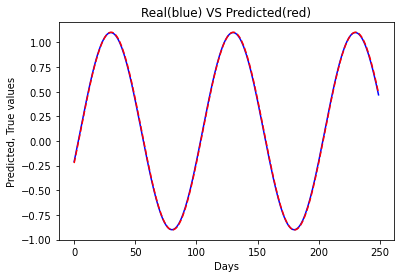

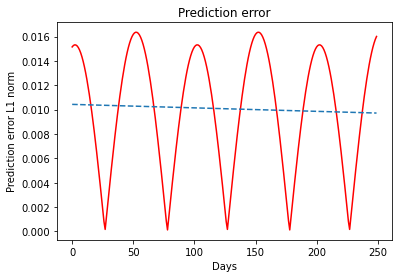

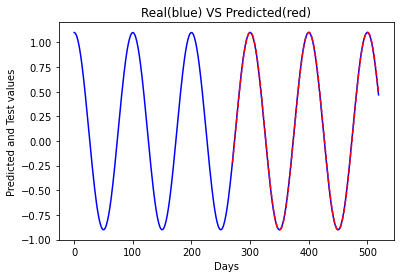

In [43]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    for i in range(n_epocs):
        train_cost, _ = sess.run([cost, train_op], feed_dict={X_tf: train_x, y_tf: test_y})
        print('Testing iteration', i, 'MSE=', train_cost)

    # 훈련된 데이터셋 성능 확인
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict={X_tf: train_x, y_tf: test_y})
    print('Test dataset:', test_cost)

    # 결과 평가
    evaluate_ts(test_x, test_y, y_pr)

    # 예측값 시각화
    plt.plot(range(len(cos_values)), cos_values, 'b')
    plt.plot(range(len(cos_values)-test_size, len(cos_values)), y_pr, 'r--')
    plt.xlabel('Days')
    plt.ylabel('Predicted and Test values')
    plt.title('Real(blue) VS Predicted(red)')
    plt.show()

In [45]:
symbol = symbol_list[0]
feat_dimension = 20
train_size = 252
test_size = 252-feat_dimension

lr = 0.05
optimizer = tf.compat.v1.train.AdamOptimizer
n_epocs = 1000

stock_values = call_stock_price(symbol, start_date, end_date)
minibatch_cos_x, minibatch_cos_y = format_dataset(stock_values, feat_dimension)
train_x = minibatch_cos_x[:train_size, :].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_x = minibatch_cos_x[train_size:, :].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)

loaded from ./tmp/prices/005930_2008-01-01_2022-06-30.pk


In [48]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    for i in range(n_epocs):
        train_cost, _ = sess.run([cost, train_op], feed_dict={X_tf: train_x, y_tf: test_y})
        print('Testing iteration', i, 'MSE=', train_cost)

    # 훈련된 데이터셋 성능 확인
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict={X_tf: train_x, y_tf: test_y})
    print('Test dataset:', test_cost)

    # 결과 평가
    evaluate_ts(test_x, test_y, y_pr)

    # 예측값 시각화
    plt.plot(range(len(cos_values)), cos_values, 'b')
    plt.plot(range(len(cos_values)-test_size, len(cos_values)), y_pr, 'r--')
    plt.xlabel('Days')
    plt.ylabel('Predicted and Test values')
    plt.title('Real(blue) VS Predicted(red)')
    plt.show()

InvalidArgumentError: Graph execution error:

Detected at node 'gradients_2/sub_2_grad/BroadcastGradientArgs' defined at (most recent call last):
    File "c:\Users\bigcare\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\bigcare\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\bigcare\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\bigcare\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\bigcare\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\bigcare\AppData\Local\Temp\ipykernel_15032\1036946250.py", line 6, in <cell line: 6>
      train_op = optimizer(lr).minimize(cost)
Node: 'gradients_2/sub_2_grad/BroadcastGradientArgs'
Incompatible shapes: [3312,1] vs. [252,1]
	 [[{{node gradients_2/sub_2_grad/BroadcastGradientArgs}}]]

Original stack trace for 'gradients_2/sub_2_grad/BroadcastGradientArgs':
  File "c:\Users\bigcare\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\bigcare\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
    self.io_loop.start()
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\Users\bigcare\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
    self._run_once()
  File "c:\Users\bigcare\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
    handle._run()
  File "c:\Users\bigcare\Anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
    await self.process_one()
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
    await dispatch(*args)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
    await result
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
    reply_content = await reply_content
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
    return super().run_cell(*args, **kwargs)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
    result = self._run_cell(
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
    return runner(coro)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bigcare\AppData\Local\Temp\ipykernel_15032\1036946250.py", line 6, in <cell line: 6>
    train_op = optimizer(lr).minimize(cost)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 477, in minimize
    grads_and_vars = self.compute_gradients(
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 603, in compute_gradients
    grads = gradients.gradients(
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 165, in gradients
    return gradients_util._GradientsHelper(
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_util.py", line 695, in _GradientsHelper
    in_grads = _MaybeCompile(grad_scope, op, func_call,
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_util.py", line 328, in _MaybeCompile
    return grad_fn()  # Exit early
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_util.py", line 696, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py", line 1336, in _SubGrad
    SmartBroadcastGradientArgs(x, y, grad))
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py", line 106, in SmartBroadcastGradientArgs
    rx, ry = gen_array_ops.broadcast_gradient_args(sx, sy)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 770, in broadcast_gradient_args
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 797, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3754, in _create_op_internal
    ret = Operation(
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2133, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)

...which was originally created as op 'sub_2', defined at:
  File "c:\Users\bigcare\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
[elided 19 identical lines from previous traceback]
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bigcare\AppData\Local\Temp\ipykernel_15032\1036946250.py", line 5, in <cell line: 5>
    cost = tf.reduce_mean(tf.square(y_tf - y_pred))
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1406, in binary_op_wrapper
    return func(x, y, name=name)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py", line 1082, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 548, in subtract
    return gen_math_ops.sub(x, y, name)
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 11174, in sub
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 797, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3754, in _create_op_internal
    ret = Operation(
  File "c:\Users\bigcare\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2133, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)
